<a href="https://colab.research.google.com/github/conwayjw97/Image-Colourisation/blob/master/src/CGANCifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
IMAGE_COUNT = 50000
TRAINING_IMAGE = 0
TEST_IMAGE = 0
BATCH_SIZE = 1000
TRAINING_EPOCHS = 400
LOAD_COLOURISATION_MODEL = False
INPUT_IMAGE = 5

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

#%load_ext tensorboard

import tensorflow as tf
import datetime, os
import matplotlib.pyplot as plt
import numpy as np
import math
import time
from scipy.ndimage.filters import gaussian_filter1d
from tensorflow.keras import datasets, layers, models, backend, utils, optimizers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive, files

drive.mount("/content/gdrive", force_remount=True)
base_dir = "/content/gdrive/My Drive/DeterministicConvNetCifar10/"

TensorFlow 2.x selected.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images = train_images / 255.0
test_images = test_images / 255.0

170500096/170498071 [==============================] - 4s 0us/step


In [0]:
train_gray_images = tf.image.rgb_to_grayscale(train_images[:IMAGE_COUNT])
test_gray_images = tf.image.rgb_to_grayscale(test_images[:IMAGE_COUNT])

In [5]:
model_dir = os.path.dirname(base_dir + "classification.h5")

json_file = open(base_dir + "classification.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
classification_model = models.model_from_json(loaded_model_json)
classification_model.load_weights(base_dir + "classification.h5", by_name=False)

opt = optimizers.SGD(lr=0.001, momentum=0.9)
classification_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

print("Loaded model from disk")

Loaded model from disk


Predicted image class: [6] - frog


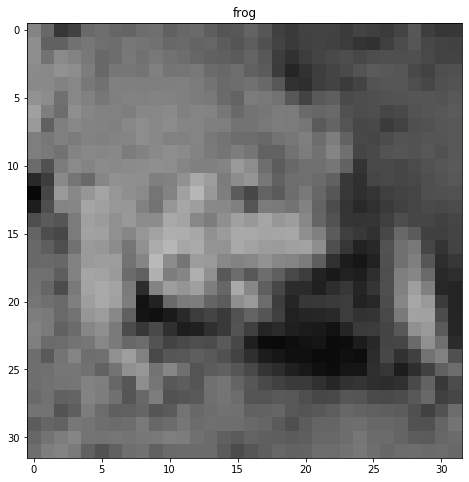

In [6]:
image_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

result = classification_model.predict_classes(tf.expand_dims(test_gray_images[INPUT_IMAGE], 0))
print("Predicted image class:", result, "-", image_labels[int(result)])
fig = plt.figure(figsize=(8,8))
plt.title(image_labels[int(result)])
plt.imshow(tf.image.grayscale_to_rgb(test_gray_images[INPUT_IMAGE]))

class_train_indices = np.argwhere(train_labels == result)
class_train_images = train_images[class_train_indices[:,0]]
class_test_indices = np.argwhere(test_labels == result)
class_test_images = test_images[class_test_indices[:,0]]

In [7]:
model_dir = os.path.dirname(base_dir + "classification.h5")

json_file = open(base_dir + "classification.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
classification_model = models.model_from_json(loaded_model_json)
classification_model.load_weights(base_dir + "classification.h5", by_name=False)

opt = optimizers.SGD(lr=0.001, momentum=0.9)
classification_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

print("Loaded model from disk")

Loaded model from disk


In [0]:
# Outputs a tensor of the same shape as the images tensor, containing the YUV 
# value of the pixels. The output is only well defined if the value in images 
# are in [0,1].
#https://zhengtq.github.io/2018/12/27/tensorflow-disturb-yuv/

train_yuvImages = tf.image.rgb_to_yuv(class_train_images[:IMAGE_COUNT])
train_y = tf.expand_dims(train_yuvImages[:,:,:,0], 3)
train_uv = train_yuvImages[:,:,:,1:]

test_yuvImages = tf.image.rgb_to_yuv(class_test_images[:IMAGE_COUNT])
test_y = tf.expand_dims(test_yuvImages[:,:,:,0], 3)
test_uv = test_yuvImages[:,:,:,1:]

# Batch the dataset
# train_y = tf.data.Dataset.from_tensor_slices(train_y).batch(BATCH_SIZE)
# train_uv = tf.data.Dataset.from_tensor_slices(train_uv).batch(BATCH_SIZE)
# test_y = tf.data.Dataset.from_tensor_slices(test_y).batch(BATCH_SIZE)
# test_uv = tf.data.Dataset.from_tensor_slices(test_uv).batch(BATCH_SIZE)



In [12]:
class GAN():
    def __init__(self):
        optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)

        # The generator takes noise as input and generated imgs
        y_image = layers.Input(shape=(32, 32, 1))
        uv_image = self.generator(y_image)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        validity = self.discriminator(uv_image)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity
        self.combined = models.Model(y_image, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

        self.gen_loss_history = []
        self.disc_loss_history = []
        self.disc_acc_history = []

    def build_generator(self):

        model = models.Sequential()

        model.add(layers.Conv2D(8, (3, 3), input_shape=(32, 32, 1)))
        model.add(layers.LeakyReLU())
        model.add(layers.Conv2D(16, (3, 3), padding='same', strides=2))
        model.add(layers.LeakyReLU())
        # model.add(layers.Dropout(0.2))
        model.add(layers.BatchNormalization(momentum=0.8))
        model.add(layers.Conv2D(32, (3, 3), padding='same', strides=2))
        model.add(layers.LeakyReLU())
        # model.add(layers.Dropout(0.2))
        model.add(layers.BatchNormalization(momentum=0.8))
        model.add(layers.Conv2D(128, (3, 3), padding='same', strides=2))
        model.add(layers.LeakyReLU())
        model.add(layers.UpSampling2D((2, 2)))
        # model.add(layers.Dropout(0.2))
        model.add(layers.BatchNormalization(momentum=0.8))
        model.add(layers.Conv2D(128, (3, 3), padding='same'))
        model.add(layers.LeakyReLU())
        model.add(layers.UpSampling2D((2, 2)))
        model.add(layers.Conv2D(32, (3, 3), padding='same'))
        model.add(layers.LeakyReLU())
        # model.add(layers.Dropout(0.2))
        model.add(layers.BatchNormalization(momentum=0.8))
        model.add(layers.Conv2D(16, (3, 3), padding='same'))
        model.add(layers.LeakyReLU())
        model.add(layers.UpSampling2D((2, 2)))
        model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))

        # model.add(Dense(256, input_shape=(32, 32, 1)))
        # model.add(LeakyReLU(alpha=0.2))
        # model.add(BatchNormalization(momentum=0.8))
        # model.add(Dense(512))
        # model.add(LeakyReLU(alpha=0.2))
        # model.add(BatchNormalization(momentum=0.8))
        # model.add(Dense(1024))
        # model.add(LeakyReLU(alpha=0.2))
        # model.add(BatchNormalization(momentum=0.8))
        # model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        # model.add(Reshape(self.img_shape))

        model.summary()

        y_image = layers.Input(shape=(32, 32, 1))
        uv_image = model(y_image)

        return models.Model(y_image, uv_image)

    def build_discriminator(self):

        model = models.Sequential()

        model.add(layers.Conv2D(16, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 2]))
        model.add(layers.LeakyReLU())
        model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same'))
        model.add(layers.LeakyReLU())
        model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
        model.add(layers.LeakyReLU())
        model.add(layers.Flatten())
        model.add(layers.Dense(1, activation='sigmoid'))

        # model.add(Flatten(input_shape=img_shape))
        # model.add(Dense(512))
        # model.add(LeakyReLU(alpha=0.2))
        # model.add(Dense(256))
        # model.add(LeakyReLU(alpha=0.2))
        # model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = layers.Input(shape=(32, 32, 2))
        validity = model(img)

        return models.Model(img, validity)

    def train(self, epochs, y_images, uv_images, save_interval=50):
        # Split the dataset into batches
        # batched_train_y = np.array(np.split(train_y, (train_y.shape[0]/BATCH_SIZE)))
        # batched_train_uv = np.array(np.split(train_uv, (train_uv.shape[0]/BATCH_SIZE)))

        self.gen_loss_history = []
        self.disc_loss_history = []
        self.disc_acc_history = []

        time_total = 0

        datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

        for epoch in range(1, epochs+1):

            # ---------------------
            #  Train Discriminator
            # ---------------------
            
            start = time.time()

            # for x_batch, y_batch in datagen.flow(train_y, train_uv, batch_size=BATCH_SIZE):
            #   # model.fit(x_batch, y_batch)
            #   print(x_batch.shape, y_batch.shape)
            #   batches += 1
            #   if batches >= len(train_y) / 32:
            #       # we need to break the loop by hand because
            #       # the generator loops indefinitely
            #       break

            # Select a random batch of images
            # class_train_indices = np.argwhere(train_labels == result)
            # class_train_images = train_images[class_train_indices[:,0]]

            # idx = np.array(np.random.randint(0, batched_train_y.shape[0]))
            # print("idx:", idx)
            # imgs = batched_train_y[idx]

            # Generate a half batch of new images
            # gen_imgs = self.generator.predict(imgs)
            gen_imgs = self.generator.predict(y_images)

            # Train the discriminator
            # d_loss_real = self.discriminator.train_on_batch(batched_train_uv[idx], np.ones((BATCH_SIZE, 1)))
            d_loss_real = self.discriminator.train_on_batch(uv_images, np.ones((uv_images.shape[0], 1)))
            # d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((BATCH_SIZE, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((gen_imgs.shape[0], 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------

            # noise = np.random.normal(0, 1, (batch_size, 100))

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            # valid_y = np.array([1] * BATCH_SIZE)
            valid_y = np.array([1] * gen_imgs.shape[0])

            # Train the generator
            # g_loss = self.combined.train_on_batch(imgs, valid_y)
            g_loss = self.combined.train_on_batch(y_images, valid_y)

            # Plot the progress
            # Add a time left predictor
            # print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            time_total += time.time()-start
            print("Epoch %d/%d - Time %fs - Estimated time left %ds - Discriminator loss: %f, acc.: %.2f%% - Generator loss: %f" % (epoch, epochs, time.time()-start, (time_total/epoch)*(epochs-epoch), d_loss[0], 100*d_loss[1], g_loss))
            self.gen_loss_history.append(g_loss)
            self.disc_loss_history.append(d_loss[0])
            self.disc_acc_history.append(100*d_loss[1])

            # If at save interval => save generated image samples
            # if epoch % save_interval == 0:
            #     self.save_imgs(epoch)

    def generate_uv_images(self, y_images):
      return self.generator.predict(y_images)

    def get_training_metrics(self):
      return self.gen_loss_history, self.disc_loss_history, self.disc_acc_history


gan = GAN()
# gan.train(TRAINING_EPOCHS, train_y, train_uv, 200)
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_iterator = datagen.flow(train_y, train_uv, batch_size=BATCH_SIZE)

for e in range(10):
  print('Epoch', e)
  batches = 0
  for x_batch, y_batch in datagen.flow(train_y, train_uv, batch_size=BATCH_SIZE):
      # model.fit(x_batch, y_batch)
      print(x_batch.shape, y_batch.shape)
      batches += 1
      if batches >= len(train_y) / 32:
          # we need to break the loop by hand because
          # the generator loops indefinitely
          break

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 16, 16, 16)        816       
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 8, 8, 32)          12832     
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 4, 4, 64)          51264     
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1024)             

KeyboardInterrupt: ignored

# Diagnostic Learning Curve

In [0]:
gen_loss_history, disc_loss_history, disc_acc_history = gan.get_training_metrics()

fig = plt.figure(figsize=(38, 9))

fig.add_subplot(1,4,1)
plt.title("Fidelity")
plt.plot(gen_loss_history, label="Generator Loss")
plt.plot(disc_loss_history, label="Discriminator Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("Fidelity.png")
# files.download("Fidelity.png") 

fig.add_subplot(1,4,2)
plt.title("Smoothed")
plt.plot(gaussian_filter1d(gen_loss_history, sigma=2), label="Generator Loss")
plt.plot(gaussian_filter1d(disc_loss_history, sigma=2), label="Discriminator Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("Smooted.png")
# files.download("Smooted.png") 

# Training Results

In [0]:
output = gan.generate_uv_images(train_y)
result = np.zeros((train_y.shape[0], 32, 32, 3))
result[:,:,:,0] = train_y[:,:,:,0]
result[:,:,:,1:] = output

output_count = 12

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Input")
  plt.imshow(tf.image.grayscale_to_rgb(train_y[TRAINING_IMAGE+i]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Original")
  plt.imshow(class_train_images[TRAINING_IMAGE+i])

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(result[TRAINING_IMAGE+i]))
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U original")
  plt.imshow(train_yuvImages[TRAINING_IMAGE+i,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U output")
  plt.imshow(result[TRAINING_IMAGE+i,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V original")
  plt.imshow(train_yuvImages[TRAINING_IMAGE+i,:,:,2])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V output")
  plt.imshow(result[TRAINING_IMAGE+i,:,:,2])

# Testing Results

In [0]:
output = gan.generate_uv_images(test_y)
result = np.zeros((test_y.shape[0], 32, 32, 3))
result[:,:,:,0] = test_y[:,:,:,0]
result[:,:,:,1:] = output
  
output_count = 12

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Input")
  plt.imshow(tf.image.grayscale_to_rgb(test_y[TEST_IMAGE+i]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Original")
  plt.imshow(class_test_images[TEST_IMAGE+i])

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(result[TEST_IMAGE+i]))
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U original")
  plt.imshow(test_yuvImages[TEST_IMAGE+i,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U output")
  plt.imshow(result[TEST_IMAGE+i,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V original")
  plt.imshow(test_yuvImages[TEST_IMAGE+i,:,:,2])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V output")
  plt.imshow(result[TEST_IMAGE+i,:,:,2])